In [1]:
#following example at https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [8]:
def animate(snapshots, file_name = "animation.gif"):


    fps = 30
    nSeconds = len(snapshots)/fps
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    im = plt.imshow(a, interpolation='none', aspect='auto', vmin=np.min(snapshots), vmax=np.max(snapshots))
    plt.colorbar()
    
    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)#, fps=30)


    print('Done! gif saved to ', file_name)

    

class MultiScaleDynamicsDataSet():
    def __init__(self, data_path, n_levels, t_array = None, map_path=None, train_ratio=0.7, valid_ratio=0.2, shuffle=True):
        # load data
        data = np.load(data_path)
        self.data = torch.tensor(data).unsqueeze(1).float()
        if t_array is None:
            self.t_array = torch.range(len(self.data)).float()
        else:
            self.t_array = torch.tensor(t_array).float()
        #
        if map_path is not None:
            map_data = 1 - np.load(map_path)
            self.map_data = torch.tensor(map_data).float()
        else:
            self.map_data = torch.ones(data.shape[-2:]).float()

        self.nt, self.nx, self.ny = data.shape
        # partition
        indices = np.arange(self.nt)
        if shuffle:
            np.random.shuffle(indices)
        n_train = int(train_ratio*self.nt)
        n_val = int(valid_ratio*self.nt)
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = self.nt - n_train - n_val
        self.train_inds = indices[:n_train]
        self.val_inds = indices[n_train:n_train+n_val]
        self.test_inds = indices[n_train+n_val:]
        
        #
        self.n_levels = n_levels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.map_data = self.map_data.to(self.device)

    def obtain_data_at_current_level(self, level):
        train_data = self.data[self.train_inds].to(self.device)

        val_data = self.data[self.val_inds].to(self.device)
        test_data = self.data[self.test_inds].to(self.device)
        
        for i in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data
    
    def get_times(self):
        train_times = self.t_array[self.train_inds]
        val_times = self.t_array[self.val_inds]
        test_times = self.t_array[self.test_inds]
        
        return train_times, val_times, test_times

    def obtain_data_of_size(self, size_per_dim):
        train_data = self.data[self.train_inds].to(self.device)
        
        n_images, _, nx, ny = train_data.shape
        
        print(train_data.shape)
        
        stride_size = int(nx/size_per_dim)
        
        op = torch.nn.Conv2d(1, 1, stride_size, stride=stride_size, padding=0).to(device)
        #averaging
        op.weight.data[0,0, :, :] = torch.ones(op.weight.data[0,0, :, :].size()).to(device) / (stride_size **2)
        new_train_data = op(train_data)

        return new_train_data
        
        
        
def apply_local_op(data, device, mode='conv', ave=True):
    """
    :param data: data to be processed
    :param device: which device is the data placed in?
    :param mode: string, 'conv' or 'deconv'
    :param ave: if to use local average or sample the center
    :return: processed data
    """
    in_channels, out_channels, _, _ = data.size()
    print("data size = ", data.shape)
    n = min(in_channels, out_channels)
    if mode == 'conv':
        op = torch.nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    elif mode == 'deconv':
        op = torch.nn.ConvTranspose2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    else:
        raise ValueError('mode can only be conv or deconv!')
    op.weight.data = torch.zeros(op.weight.data.size()).to(device)
    op.bias.data = torch.zeros(op.bias.data.size()).to(device)

    for i in range(n):
        if mode == 'conv':
            if ave:
                op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 9
            else:
                op.weight.data[i, i, 1, 1] = torch.ones(op.weight.data[i, i, 1, 1].size()).to(device)
        elif mode == 'deconv':
            op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 4
            op.weight.data[i, i, 0, 1] += 1 / 4
            op.weight.data[i, i, 1, 0] += 1 / 4
            op.weight.data[i, i, 1, 2] += 1 / 4
            op.weight.data[i, i, 2, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 2

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False

    return op(data)


def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)


cpu


torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
Animating, may take a little while...
..................Done! gif saved to  4x4.gif


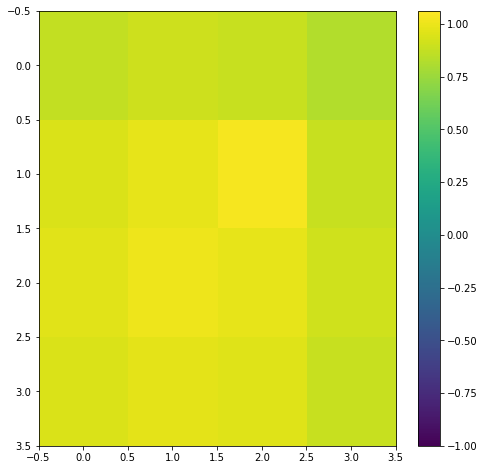

In [9]:
#make data set

data_path = '../data/npy/toy1.npy'
t = np.linspace(0, 8*np.pi, 500)
dataset =MultiScaleDynamicsDataSet(data_path, n_levels=0, t_array=t, train_ratio=1.0,  valid_ratio=0.0, shuffle = False)
data,_,_ = dataset.obtain_data_at_current_level(level=0)

data_new = dataset.obtain_data_of_size(2).detach().numpy()
train_times, _, _ = dataset.get_times()
# animate(data_new, file_name = "2x2.gif")

animate(dataset.obtain_data_of_size(4).detach().numpy(), file_name = "4x4.gif")

In [4]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.convfirst = nn.Conv2d(1, 1, 3, stride = 2, padding=0)  
        self.conv1 = nn.Conv2d(1, 1, 3, stride = 1, padding=1)  
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(1, 1, 3, stride=1, padding=1)
        self.t_conv_last = nn.ConvTranspose2d(1, 1, 3, stride=2, padding=0)


    def forward(self, x):
        x = F.relu(self.convfirst(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1(x))
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), 'replicate')
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv_last(x))
        x = x[:, :, 2:-2, 2:-2]
        return x

    def encode(self, x):
        x = F.relu(self.convfirst(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1(x))
        return x
    
    def decode(self, x):
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), 'replicate')
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv_last(x))
        x = x[:, :, 2:-2, 2:-2]
        
        return x

#Instantiate the model
model = ConvAutoencoder()
print(model)
model(images)

ConvAutoencoder(
  (convfirst): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv1): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv_last): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
)


NameError: name 'images' is not defined

In [ ]:
#Loss function
criterion = nn.BCELoss()
# criterion = nn.MSELoss()#reduction='none')

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = get_device()
print(device)
model.to(device)

In [ ]:
#Epochs
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

#     i = 0
    #Training
    for images in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [ ]:
#Batch of test images
dataiter = iter(train_loader)
images = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

print(images.shape)
batch_size = 50
output = output.view(batch_size, 1, 31, 31)#127, 127)
output = output.detach().numpy()

image_min = np.min(images)
image_max = np.max(images)
print("image_min = ", image_min)
print("image_max = ", image_max)

print("output min = ", np.min(output))
print("output max = ", np.max(output))
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    print(images[idx][0].shape)
    imshow(images[idx])#[0], vmin = -2.5, vmax = 2.5)
#     ax.set_title(classes[labels[idx]])
plt.colorbar()
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    plt.colorbar()
#     ax.set_title(classes[labels[idx]])
plt.show() 

In [ ]:
plt.figure()
plt.imshow(data_new[0][0])
plt.colorbar()
plt.show()

animate(data_new, file_name = "2x2.gif")

In [ ]:
#now we want to evolve our 2x2 forward in time

class time_net(nn.Module):
    def __init__(self):
        super(time_net, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

time_model = time_net()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(time_model.parameters(), lr=1e-3)

inputs = torch.tensor(data_new[:-1])
inputs = torch.flatten(inputs, start_dim=1, end_dim=-1)
np.save("inputs_2x2.npy", inputs.detach().numpy())
print("inputs.shape = ", inputs.shape)
outputs = torch.tensor(data_new[1:])
outputs = torch.flatten(outputs, start_dim=1, end_dim=-1)
print("outputs.shape = ", outputs.shape)
n_epochs = 50000
for t in range(n_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    predicted = time_model(inputs)
    
    # Compute and print loss
    loss = criterion(predicted, outputs)
    if t % 1000 == 0:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
n_steps_predict = 100

predicted = inputs[0]
current = inputs[0]
for i in range(n_steps_predict):
    next_step = time_model(current)#.reshape(1, 1, 2, 2)
    predicted = torch.cat((predicted,next_step), 0)
    current = next_step
#     print(predicted.shape)
    
predicted = predicted.reshape(n_steps_predict+1, 1, 2, 2).detach().numpy()

plt.figure()
plt.imshow(predicted[n_steps_predict][0])
plt.colorbar()
plt.show()

plt.figure()
inputs_np = inputs.reshape(499,1,2,2).detach().numpy()
plt.imshow(inputs_np[n_steps_predict][0])
plt.colorbar()
plt.show()

    
gh

predicted = time_model(inputs).reshape(499, 1, 2, 2).detach().numpy()

print(predicted.shape)
plt.figure()
plt.imshow(predicted[0][0],vmin = .8, vmax = 1.0)
plt.colorbar()
plt.show()

inputs_np = inputs.reshape(499, 1, 2, 2).detach().numpy()
plt.figure()
plt.imshow(inputs_np[1][0],vmin = .8, vmax = 1.0)
plt.colorbar()
plt.show()

In [ ]:
animate(predicted, "2x2_predicted.gif")

In [ ]:
mse = np.sqrt((inputs_np[:101,0] - predicted[:,0])**2)
total_mse = mse[:,0,0] + mse[:,0,1] + mse[:,1,0] + mse[:,1,1]
print(total_mse.shape)


t = np.linspace(0, 8*np.pi, 500)
w0 = 0.5

fig,ax = plt.subplots()
ax.plot(t[:101],total_mse, "r")
# ax.set_y_label("MSE")
ax2=ax.twinx()
# ax2.plot(t[1:], np.cos(w0*t[1:]),"b")
plt.title("Total Error")
plt.show()

In [ ]:
print(inputs_np.shape)
sum_all  = inputs_np[:,:,0,0] + inputs_np[:,:,0,1] + inputs_np[:,:,1,0] + inputs_np[:,:,1,1]
sum_all.shape
# plt.plot(sum_all)

fig,ax = plt.subplots()
ax.plot(t[1:],sum_all, "r")
# ax.set_y_label("MSE")
ax2=ax.twinx()
ax2.plot(t[1:], np.cos(w0*t[1:]),"b")
plt.title("Sum of all points")
plt.show()

In [ ]:
plt.figure()

mse = np.sqrt((inputs_np[:,0] - predicted[:,0])**2)

plt.plot(t[1:], mse[:,0,0], label = "(0,0)")
plt.plot(t[1:], mse[:,1,0], label = "(1,0)")
plt.plot(t[1:], mse[:,0,1], label = "(0,1)")
plt.plot(t[1:], mse[:,1,1], label = "(1,1)")
plt.legend()
plt.show()